In [1]:
%load_ext autoreload

In [777]:
%autoreload
import pickle
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import (
    DeepLift,
    FeatureAblation,
    GradientShap,
    IntegratedGradients,
    NoiseTunnel,
    Occlusion,
    GradientShap,
)
from spender.data.desi import DESI
from outlier_attribution.model import OutlierModel
from tqdm.auto import tqdm
from scipy.signal import savgol_filter

plt.style.use("js")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [154]:
trainloader = DESI.get_data_loader(
    "/scratch/gpfs/yanliang/desi-dynamic",
    which="train",
    batch_size=64,
    shuffle=True,
    shuffle_instance=True,
)

In [155]:
def get_baselines():
    s, _, _ = next(iter(trainloader))
    s = s.to(device).reshape(64, len(DESI._wave_obs))
    # z = z.to(device)
    return s

In [35]:
weight_dir = "/scratch/gpfs/js5013/programs/outlier-attribution/weights"
model = OutlierModel.from_weights(
    f"{weight_dir}/spender.desi-edr.galaxyae-b9bc8d12.pt",
    f"{weight_dir}/galaxy-flow-state_dict.pt",
).to(device)

In [192]:
with open("../data/DESI_EDR_top200_outliers.pkl", "rb") as f:
    data = pickle.load(f)

spectra = (
    torch.tensor(np.stack([data[i]["spectrum"] for i in range(1, 201)]))
    .to(device)
    .requires_grad_()
)
weights = (
    torch.tensor(np.stack([data[i]["weight"] for i in range(1, 201)]))
    .to(device)
    .requires_grad_()
)

In [8]:
selkeys = ["target_id", "z", "ra", "dec", "-logP"]
metadata = dict(
    zip(
        selkeys,
        (
            torch.tensor(np.stack([data[i][k] for i in range(1, 201)])).to(device)
            for k in selkeys
        ),
    )
)

In [234]:
ig = IntegratedGradients(model)
fa = FeatureAblation(model)
oc = Occlusion(model)

In [122]:
def expected_gradients(spectrum, baselines, z):
    spectrum = spectrum.unsqueeze(0)
    attributions = []
    aligned_baselines = []
    for b in baselines:
        aligned_baseline = model.reconstruct(b, z).float() # put at same redshift first!!
        aligned_baselines.append(aligned_baseline)
        attributions.append(ig.attribute(spectrum, aligned_baseline.unsqueeze(0)))
    aligned_baselines = torch.stack(aligned_baselines)
    attributions = torch.stack(attributions).squeeze(1)
    baseline_weights = torch.softmax(torch.vmap(model)(baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)
    return torch.sum(attributions * baseline_weights, dim=0).detach().cpu().numpy(), aligned_baselines.detach().cpu().numpy()

In [233]:
def instantaneous_gradient(spectrum):
    mdl = lambda x: model(x.unsqueeze(0)).squeeze()
    attribution = torch.func.grad(mdl)(spectrum) * spectrum
    return attribution.detach().cpu().numpy()

In [952]:
def feature_ablation(spectrum, baseline):
    with torch.no_grad():
        assert spectrum.shape == baseline.shape
        assert spectrum.ndim == 1
        mask = torch.ones_like(spectrum, dtype=bool) # all like spectrum
        ref_output = model(spectrum.unsqueeze(0)).squeeze() # reference output to compare to
        grad = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store grads
        new = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store new array
        for i in tqdm(range(len(spectrum)), leave=False):
            mask[i] = False # replace spectral element with baseline
            new[:] = torch.where(mask, spectrum, baseline)
            new_output = model(new.unsqueeze(0)).squeeze() # calculate new output
            grad[i] = ref_output - new_output # save difference
            mask[i] = True # put spectra element back
        return grad

def random_ablation(spectrum, baselines, z, mask_frac=0.05, iterations=10):
    with torch.no_grad():
        attributions = []
        aligned_baselines = []
        for b in baselines:
            aligned_baselines.append(model.reconstruct(b, z))
        aligned_baselines = torch.stack(aligned_baselines).float()
        baseline_weights = torch.softmax(torch.vmap(model)(aligned_baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)

        ref_output = model(spectrum.unsqueeze(0)).squeeze() # reference output to compare to
        
        grad = torch.zeros((len(baselines), len(spectrum)), dtype=spectrum.dtype).to(spectrum.device) # store grads
        temp_grad = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store grads
        new = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store new array
        counts = torch.zeros_like(spectrum, dtype=spectrum.dtype)
        for i, b in tqdm(enumerate(aligned_baselines), total=len(baselines)):
            temp_grad[:] = 0.
            counts[:] = 0.
            for _ in range(iterations):
                mask = torch.tensor(np.random.choice(2, size=len(spectrum), replace=True, p=[mask_frac, 1-mask_frac]), dtype=bool).to(spectrum.device) # replace 10% with baseline
                new[:] = torch.where(mask, spectrum, b) # 90% spectrum, 10% baseline
                new_output = model(new.unsqueeze(0)).squeeze() # calculate new output
                temp_grad[~mask] += ref_output - new_output # accumulate difference in all masked pixels
                counts[~mask] += 1.
            div_mask = torch.where(counts > 0.)
            # print((counts > 0.).sum())
            grad[i][div_mask] = (temp_grad / counts)[div_mask]

        return torch.sum(grad * baseline_weights, dim=0).detach().cpu().numpy()

def expected_ablation(spectrum, baselines, z):
    with torch.no_grad():
        attributions = []
        aligned_baselines = []
        for b in baselines:
            aligned_baselines.append(model.reconstruct(b, z))
        aligned_baselines = torch.stack(aligned_baselines).float()
        baseline_weights = torch.softmax(torch.vmap(model)(aligned_baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)
        for b in tqdm(aligned_baselines):
            attributions.append(feature_ablation(spectrum, b))
        attributions = torch.stack(attributions)
        return torch.sum(attributions * baseline_weights, dim=0).detach().cpu().numpy(), aligned_baselines.detach().cpu().numpy()


def no_overlap_occlusion(spectrum, baseline, window_size, offset):
    with torch.no_grad():
        assert spectrum.shape == baseline.shape
        assert spectrum.ndim == 1
        
        ref_output = model(baseline.unsqueeze(0)).squeeze() # reference output to compare to
        grad = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store grads
        new = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store new array

        n_shifts = []
        offset = offset % window_size
        stride = window_size
        npix = len(spectrum)
        chunks = int(np.ceil(len(spectrum[offset:]) / window_size))
        if offset > 0:
            chunks += 1

        ctr = 0
        mask = torch.ones_like(spectrum, dtype=bool) # all like spectrum
        
        for i in range(chunks):
            if offset > 0:
                if i == 0: # check for offset in first block
                    mask[:offset] = False # just mask the first few elements for first chunk
                else:
                    mask[ctr : ctr + window_size] = False
            else:
                mask[ctr : ctr + window_size] = False # do things normally, mask whole window

            new[:] = torch.where(mask, baseline, spectrum)#, baseline)
            new_output = model(new.unsqueeze(0)).squeeze() # calculate new output
            grad[ctr : ctr + window_size] = (ref_output - new_output) / window_size # save difference in all masked pixels

            # put spectral elements back
            if offset > 0:
                if i == 0: # check for offset in first block
                    mask[:offset] = True # just mask the first few elements for first chunk
                    ctr += offset
                else:
                    mask[ctr : ctr + window_size] = True
                    ctr += stride
            else:
                mask[ctr : ctr + window_size] = True
                ctr += stride # move over by stride
        
        return grad


def multiscale_occlusion(spectrum, baselines, z, window_sizes=[8, 16, 32, 64, 128, 256], offsets=[0, 0, 0, 0, 0, 0]):
    assert len(window_sizes) == len(offsets)
    with torch.no_grad():
        attributions = []
        aligned_baselines = []
        for b in tqdm(baselines):
            aligned_baselines.append(model.reconstruct(b, z))
        aligned_baselines = torch.stack(aligned_baselines).float()
        baseline_weights = torch.softmax(torch.vmap(model)(aligned_baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)
        for b in tqdm(aligned_baselines):
            attributions.append(torch.mean(torch.stack([no_overlap_occlusion(spectrum, b, ws, os) for ws, os in zip(window_sizes, offsets)]), dim=0))
            # attributions.append(torch.mean(torch.stack([oc.attribute(spectrum.unsqueeze(0), sliding_window_shapes=(bs,), strides=(bs,), baselines=b.unsqueeze(0)) for bs in scales]), dim=0))
        attributions = torch.stack(attributions).squeeze(1)
        return torch.sum(attributions * baseline_weights, dim=0).detach().cpu().numpy(), aligned_baselines

In [823]:
attribution_labels = [
    "Gradient",
    "Expected Gradients",
    "Expected Ablation",
    "Multiscale Occlusion",
    "Random Ablation",
]

In [959]:
ix = 13

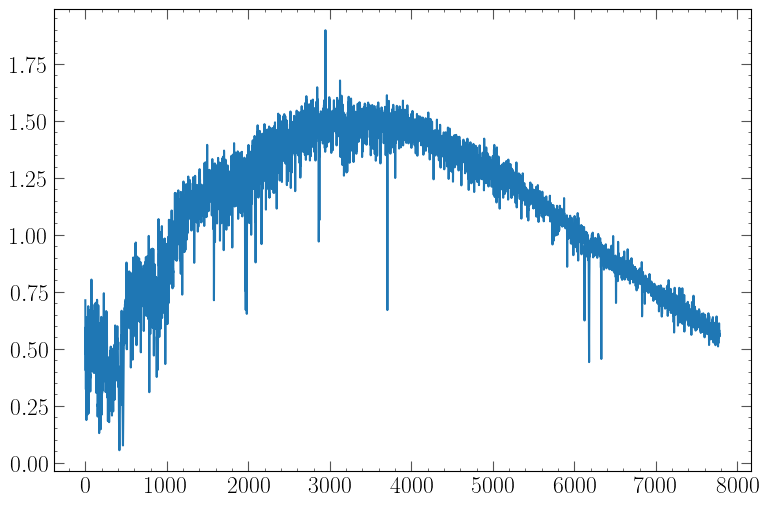

In [960]:
plt.plot(spectra[ix].detach().cpu())

In [961]:
bl = get_baselines()
# inst_attr = instantaneous_gradient(spectra[ix])
# eg_attr = expected_gradients(spectra[ix], bl, metadata['z'][ix])
# efa_attr = expected_ablation(spectra[ix], bl[:8], metadata['z'][ix])
mso_attr, abl = multiscale_occlusion(spectra[ix], bl[:3], metadata['z'][ix], window_sizes=[ 2**(2*k) for k in range(1,7)], offsets=list(np.cumsum([0,] + [ 2**(2*k-1) for k in range(1,6) ])))
# ra_attr = random_ablation(spectra[ix], bl, metadata['z'][ix], mask_frac=0.2, iterations=50)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [962]:
attributions = np.stack([inst_attr, eg_attr[0], efa_attr[0], mso_attr, savgol_filter(ra_attr, 151, 1)])

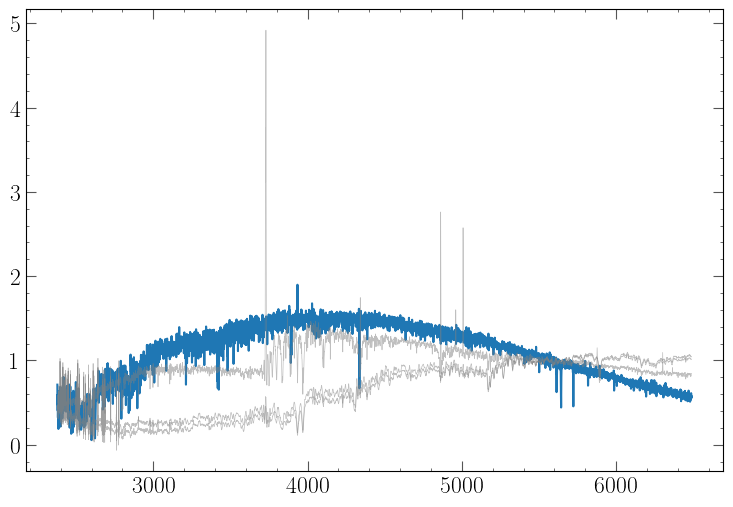

In [964]:
plt.plot(DESI._wave_obs / (1 + metadata['z'][ix].item()), spectra[ix].detach().cpu())
plt.plot(DESI._wave_obs / (1 + metadata['z'][ix].item()), abl[:3].detach().cpu().numpy().T, alpha=0.5, c='gray', lw=0.5)

Text(0.5, 0.98, 'Outlier 14\nID=39632956888715615, z=0.5140\nRA=253.77380, Dec=33.74953\nlogP=-20.432')

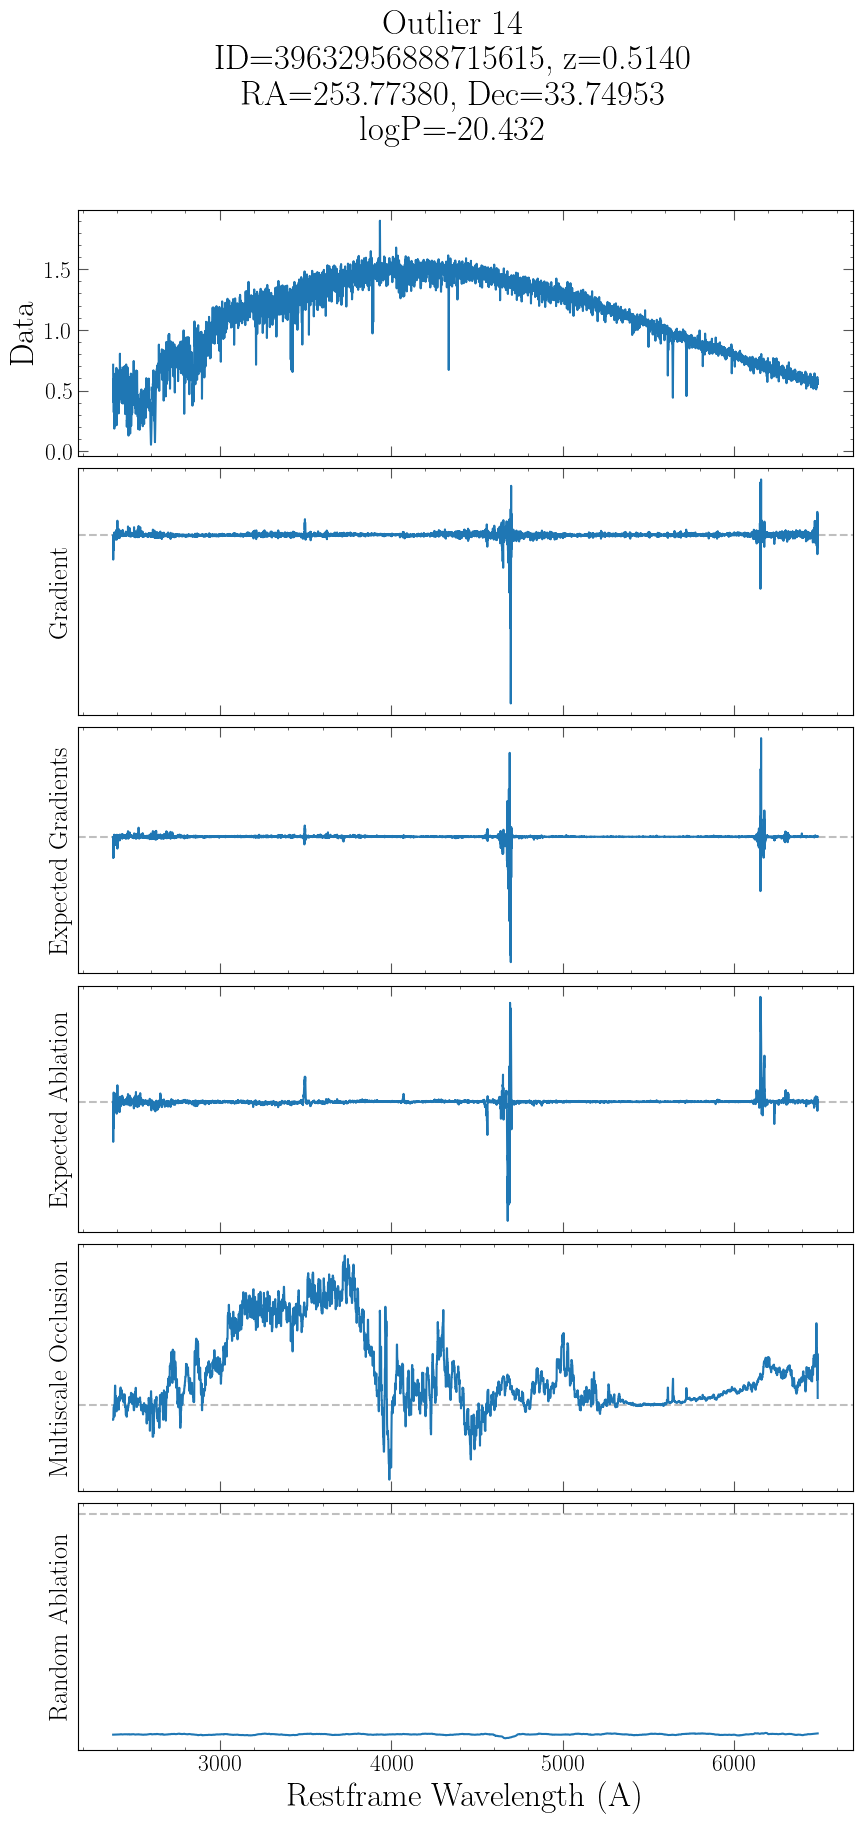

In [965]:
nattr = len(attributions)

fig, ax = plt.subplots(
    nattr + 1, 1, figsize=(10, 5 + nattr * 3), sharex=True, gridspec_kw=dict(hspace=0.05)
)

ax[0].plot(
    DESI._wave_obs / (1 + metadata['z'][ix].item()),
    spectra[ix].detach().cpu().numpy(),
)
[]
[
    ax[j + 1].plot(
        DESI._wave_obs / (1 + metadata['z'][ix].item()),
        attributions[j], # np.sqrt(weights[ix].detach().cpu().numpy()),
        label=attribution_labels[j],
    )
    for j in range(nattr)
]
ax[0].set_ylabel("Data")
for j in range(nattr):
    ax[j + 1].axhline(0, c="gray", alpha=0.5, ls="--", zorder=-5)
    ax[j + 1].set_ylabel(attribution_labels[j], fontsize=19)
    ax[j + 1].set_yticks([])
    # ax[j + 1].set_ylim(*torch.quantile(attributions[0], torch.tensor([0.01, 0.99]).double().to(device)).detach().cpu().numpy())
    # ax[j + 1].set_xlim(8600, 8800)
plt.xlabel("Restframe Wavelength (A)")
plt.suptitle(
    f"Outlier {ix + 1}\nID={metadata['target_id'][ix]}, z={metadata['z'][ix]:.4f}\nRA={metadata['ra'][ix]:.5f}, Dec={metadata['dec'][ix]:.5f}\nlogP={-metadata['-logP'][ix]:.3f}",
    fontsize=25,
)
# plt.xlim(4800, 5100)
# plt.savefig('example-attribution-1.pdf', dpi=250, bbox_inches='tight')